In [19]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import tensorflow.keras.layers as tfl
from keras.preprocessing import image_dataset_from_directory
from keras.layers import RandomFlip, RandomRotation


In [20]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)

directory = "archive/dataset/training_set"


train_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='training',
                                             seed=42)
validation_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='validation',
                                             seed=42)

Found 8000 files belonging to 2 classes.
Using 6400 files for training.
Found 8000 files belonging to 2 classes.
Using 1600 files for validation.


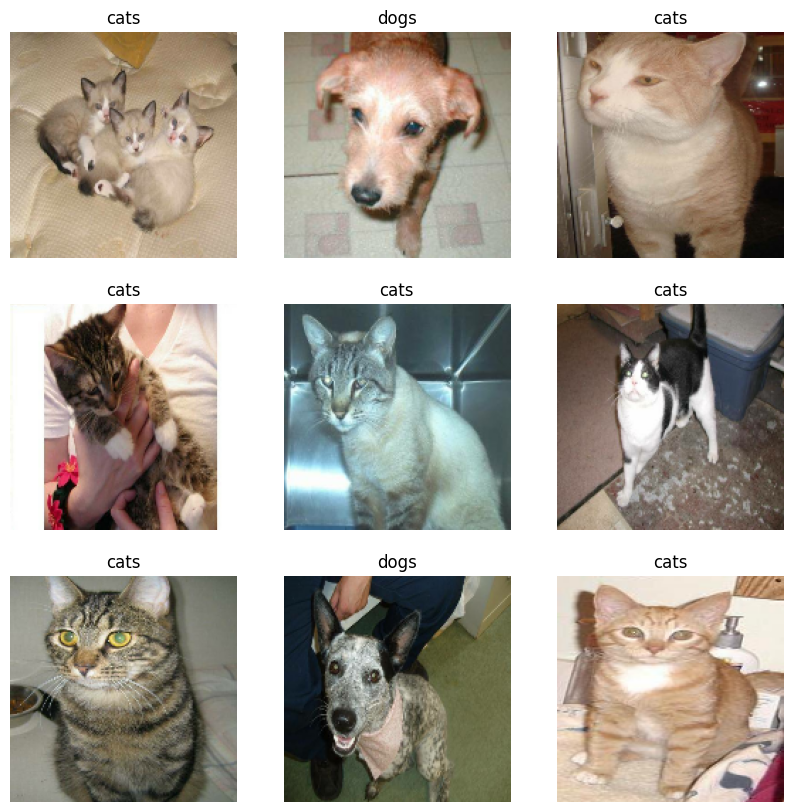

In [21]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [22]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

In [23]:
def data_augmenter():
    data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal"),
  tf.keras.layers.RandomRotation(0.2),
])
    # YOUR CODE ENDS HERE
    
    return data_augmentation

In [24]:
augmenter = data_augmenter()


print('\033[92mAll tests passed!')

All tests passed!


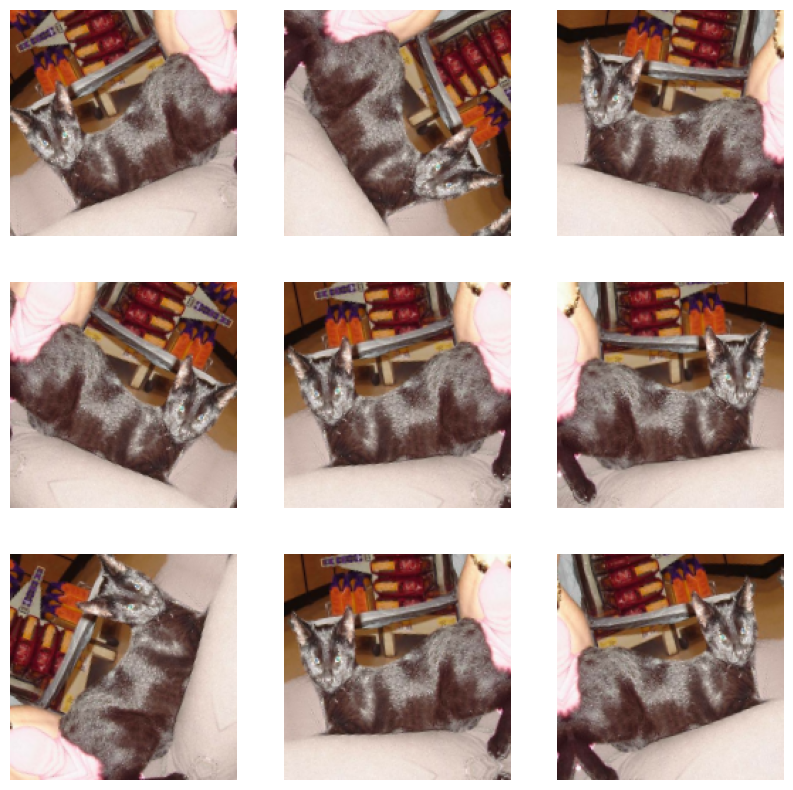

In [25]:
data_augmentation = data_augmenter()
for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

In [26]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [27]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=True,
                                               weights='imagenet')

In [28]:
base_model.summary()

Model: "mobilenetv2_1.00_160"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 80, 80,    │        864 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 80, 80,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 80, 80,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 80, 80,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 80, 80,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 80, 80,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 81, 81,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 40, 40,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 40, 40,    │      2,304 │ block_1_depthwis

 Total params: 3,538,984 (13.50 MB)

 Trainable params: 3,504,872 (13.37 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [29]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 1000)


In [30]:
base_model.trainable = False
image_var = tf.Variable(image_batch)
pred = base_model(image_var)

tf.keras.applications.mobilenet_v2.decode_predictions(pred.numpy(), top=2)

[[('n04589890', 'window_screen', 0.06601715),
  ('n02085620', 'Chihuahua', 0.056366898)],
 [('n04589890', 'window_screen', 0.43442366),
  ('n02098286', 'West_Highland_white_terrier', 0.05846656)],
 [('n04589890', 'window_screen', 0.0906914), ('n13133613', 'ear', 0.04135417)],
 [('n03598930', 'jigsaw_puzzle', 0.44027454),
  ('n03530642', 'honeycomb', 0.05660139)],
 [('n03733281', 'maze', 0.20350114),
  ('n02098286', 'West_Highland_white_terrier', 0.17489263)],
 [('n03207743', 'dishrag', 0.07587409), ('n03733281', 'maze', 0.075394675)],
 [('n04589890', 'window_screen', 0.4357589),
  ('n03887697', 'paper_towel', 0.043591414)],
 [('n02098286', 'West_Highland_white_terrier', 0.098640926),
  ('n02101556', 'clumber', 0.060798503)],
 [('n04589890', 'window_screen', 0.45245826),
  ('n02085620', 'Chihuahua', 0.032312255)],
 [('n02085620', 'Chihuahua', 0.08854495),
  ('n02098286', 'West_Highland_white_terrier', 0.045522343)],
 [('n03598930', 'jigsaw_puzzle', 0.19422883),
  ('n03733281', 'maze', 0

In [31]:
def alpaca_model(image_shape=IMG_SIZE, data_augmentation=data_augmenter()):
    input_shape = image_shape + (3,)
    base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                                include_top=False,
                                                weights='imagenet')
    base_model.trainable = False
    inputs = tf.keras.Input(shape=input_shape)
    x = data_augmentation(inputs)
    x = preprocess_input(x)
    x = base_model(x, training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tfl.Dropout(.2)(x)
    prediction_layer = tf.keras.layers.Dense(1)
    
    outputs = prediction_layer(x) 
    model = tf.keras.Model(inputs, outputs)
    return model

In [32]:
model2 = alpaca_model(IMG_SIZE, data_augmentation)

In [33]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 1000)


In [35]:
base_learning_rate = 0.01
model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [36]:
initial_epochs = 5
history = model2.fit(train_dataset, validation_data=validation_dataset, epochs=initial_epochs)

Epoch 1/5
200/200 ━━━━━━━━━━━━━━━━━━━━ 55s 258ms/step - accuracy: 0.9072 - loss: 0.2211 - val_accuracy: 0.9731 - val_loss: 0.1004
Epoch 2/5
200/200 ━━━━━━━━━━━━━━━━━━━━ 50s 251ms/step - accuracy: 0.9408 - loss: 0.1951 - val_accuracy: 0.9744 - val_loss: 0.1150
Epoch 3/5
200/200 ━━━━━━━━━━━━━━━━━━━━ 48s 239ms/step - accuracy: 0.9441 - loss: 0.1814 - val_accuracy: 0.9819 - val_loss: 0.0748
Epoch 4/5
200/200 ━━━━━━━━━━━━━━━━━━━━ 47s 235ms/step - accuracy: 0.9535 - loss: 0.1795 - val_accuracy: 0.9787 - val_loss: 0.0629
Epoch 5/5
200/200 ━━━━━━━━━━━━━━━━━━━━ 49s 243ms/step - accuracy: 0.9475 - loss: 0.1892 - val_accuracy: 0.9781 - val_loss: 0.0738
